In [1]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *
import tensorflow as tf
import numpy as np
import baseline_model

c:\Users\phong\.conda\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Data preparation

In [4]:
no_of_sensor = 8
# Prepare field data
Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_train:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_array = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_array = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_array.shape)
print(full_field_data_whole_array.shape)

# Normalization
min_val = np.amin(full_field_data_whole_array)
max_val = np.amax(full_field_data_whole_array)
full_field_data_whole_array_norm = (full_field_data_whole_array - min_val)/(max_val - min_val)
sensor_data_whole_array_norm = (sensor_data_whole_array - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_array_norm), np.amax(full_field_data_whole_array_norm))
print("Check sens data: ", np.amin(sensor_data_whole_array_norm), np.amax(sensor_data_whole_array_norm))

target_shape = full_field_data_whole_array_norm.shape
full_field_data_flattened = np.reshape(full_field_data_whole_array_norm, (target_shape[0], target_shape[1]*target_shape[2]*target_shape[3]))
full_field_data_flattened.swapaxes(0,1)

(429, 8)
(429, 128, 256, 1)
Check field data:  0.0 1.0
Check sens data:  0.013270650800024661 0.766168138177504
<BatchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float64, name=None))>


## Training

In [4]:
# POD
import modred as mr

num_modes = 128
POD_res = mr.compute_POD_arrays_snaps_method(
    full_field_data_flattened, list(mr.range(num_modes)))
modes = POD_res.modes

np.save(modes, 'pod_modes.npy')                         

(100, 30)


In [ ]:
# Computed latent vector
z_pod = np.multiply(modes,full_field_data_flattened)
z_pod.swapaxes(0,1)

# Create tf.dataset
dataset = tf.data.Dataset.from_tensor_slices((sensor_data_whole_array_norm,z_pod))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)


In [ ]:
tf.keras.backend.clear_session()
mlp_recon = baseline_model.MLP_POD(no_of_sensor = no_of_sensor)
mlp_recon.summary()
mlp_recon.compile(loss= 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005, beta_1 = 0.9, beta_2 = 0.999))
mlp_recon.fit(dataset, epochs =  400, shuffle = True)
mlp_recon.save_weights('mlp_pod.h5')

In [7]:
# Save model weight
# Prepare field data

Re_list_train = [300, 400, 450, 500, 600, 650, 700, 800, 850, 900, 1000]
Re_list_test = [350, 550, 750, 950]

sensor_data_whole = []
full_field_data_whole = []
for Re in Re_list_test:
    filename = "E:/Research/Data/flow_field_recon/random_sensor_data/sensor_data_" + str(no_of_sensor) + "_" + str(Re) + ".npy"
    sensor_data = np.load(filename)
    sensor_data_whole.append(sensor_data)
    filename_field = "E:/Research/Data/flow_field_recon/full_field_data/full_field_data_" + str(Re) + ".npy"
    full_field_data_whole.append(np.load(filename_field))

sensor_data_whole_test = np.swapaxes(np.concatenate(sensor_data_whole,axis = -1), 0,1)
full_field_data_whole_test = np.swapaxes(
    np.expand_dims(
        np.concatenate(full_field_data_whole, axis = -1), axis = 0),
        0, -1)

print(sensor_data_whole_test.shape)
print(full_field_data_whole_test.shape)

full_field_data_whole_test_norm = (full_field_data_whole_test - min_val)/(max_val - min_val)
sensor_data_whole_test_norm = (sensor_data_whole_test - min_val)/(max_val - min_val)

# Test
print("Check field data: ", np.amin(full_field_data_whole_test_norm), np.amax(full_field_data_whole_test_norm))
print("Check sens data: ", np.amin(sensor_data_whole_test_norm), np.amax(sensor_data_whole_test_norm))

(156, 8)
(156, 128, 256, 1)
Check field data:  0.0 0.9929987273789493
Check sens data:  0.04263783972866182 0.7515328263773662


In [12]:
# Save model weight
# Reconstruction
case_idx = 3
reconstruction_sens_mlp = mlp_recon(sensor_data_whole_test_norm[39*case_idx:(39*(case_idx +1)),:])
reconstruction_sens_mlp.swapaxes(0,1)

reconstruction_sens = np.multiply(np.transpose(modes),reconstruction_sens_mlp)
reconstruction_sens.swapaxes(0,1)
reconstruction_sens.reshape(39,128,256,1)

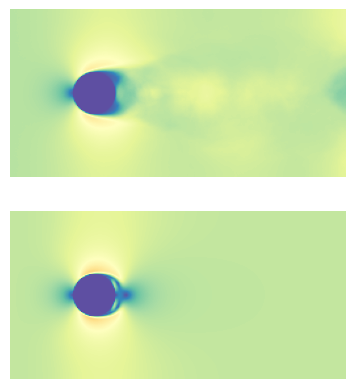

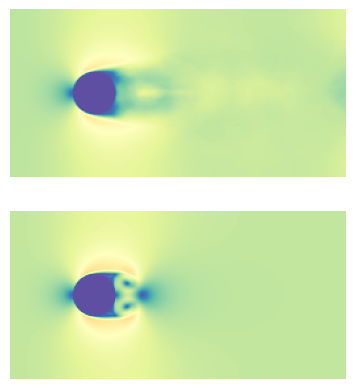

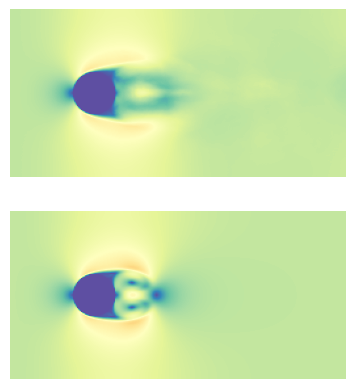

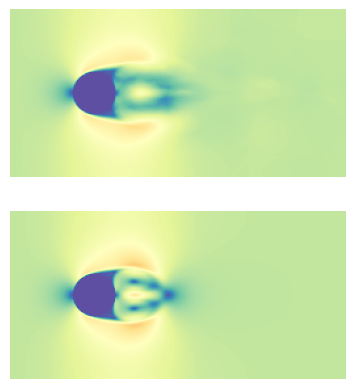

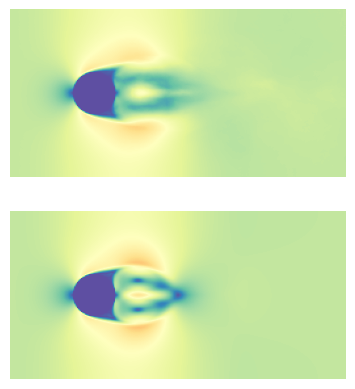

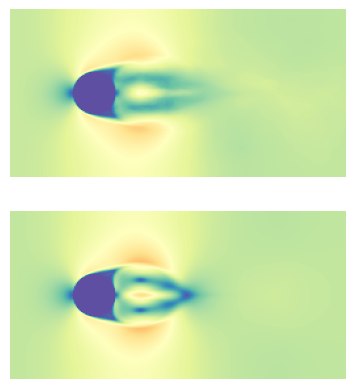

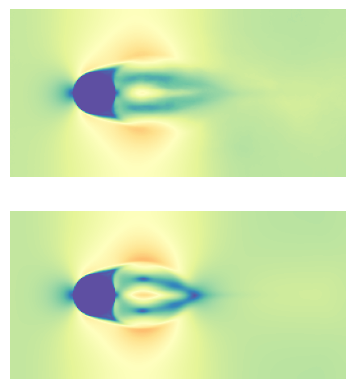

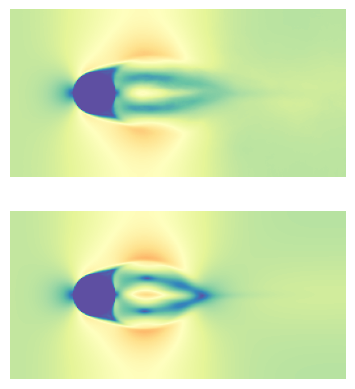

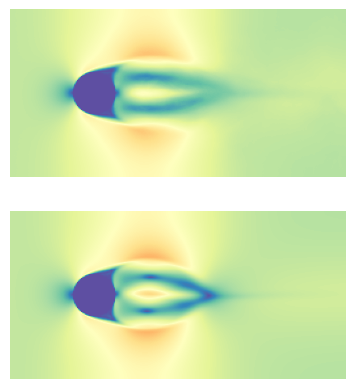

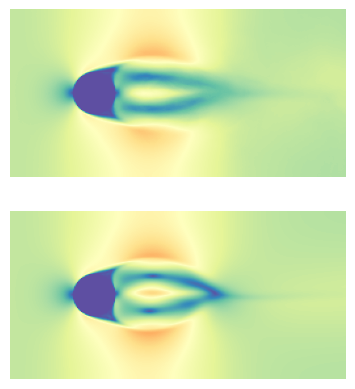

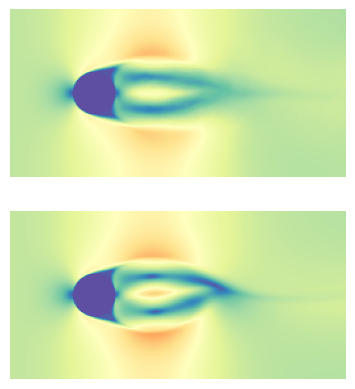

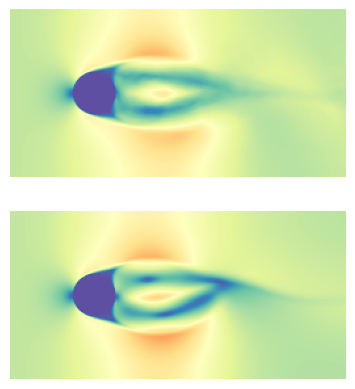

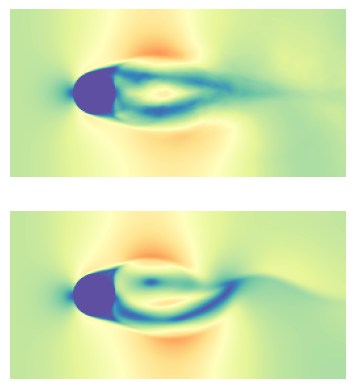

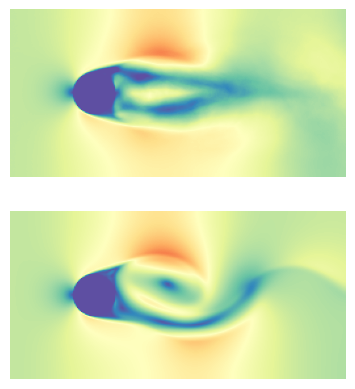

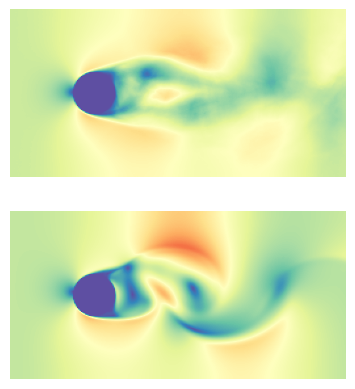

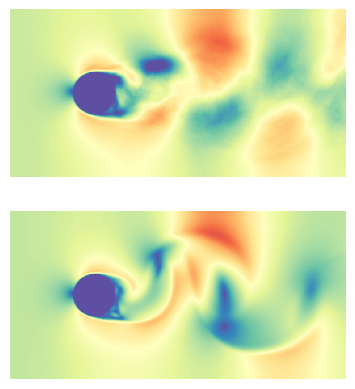

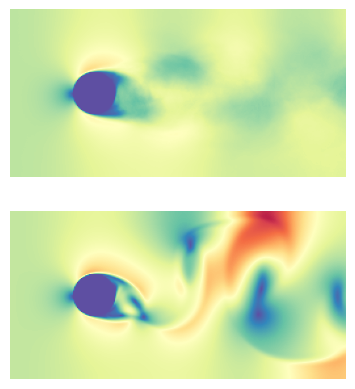

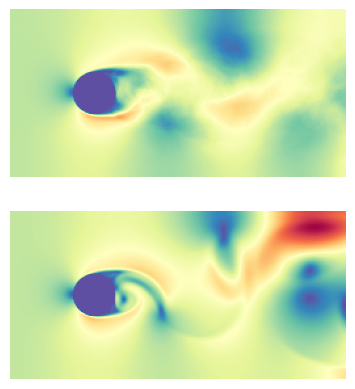

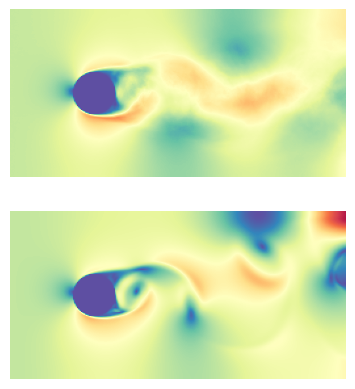

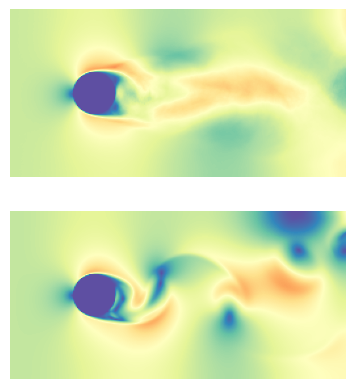

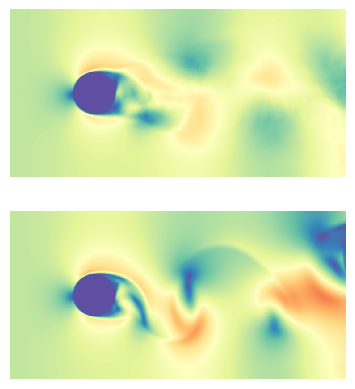

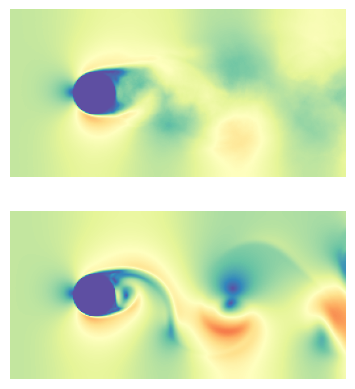

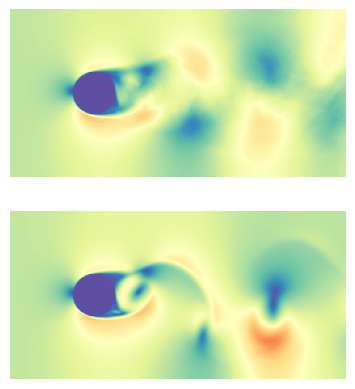

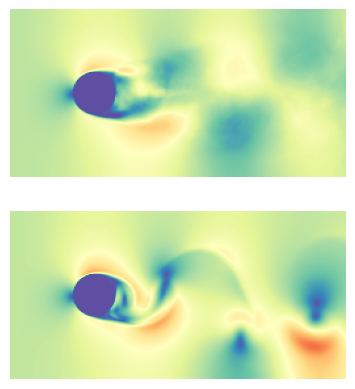

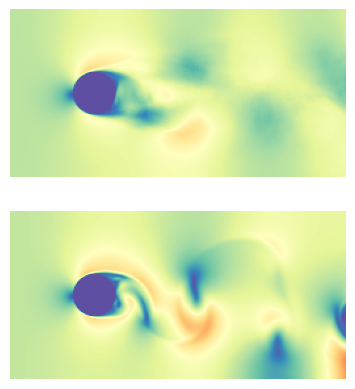

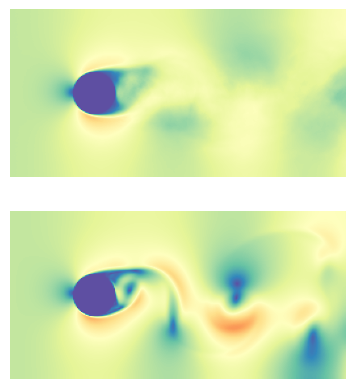

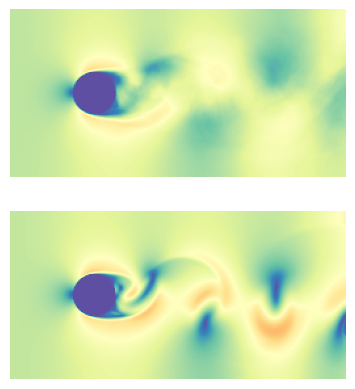

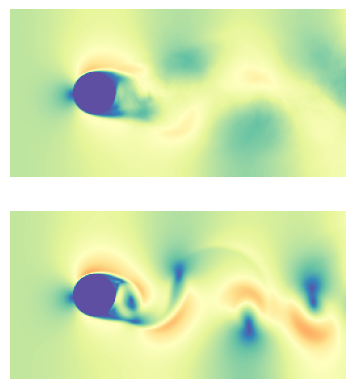

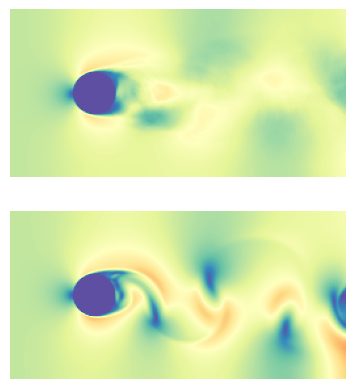

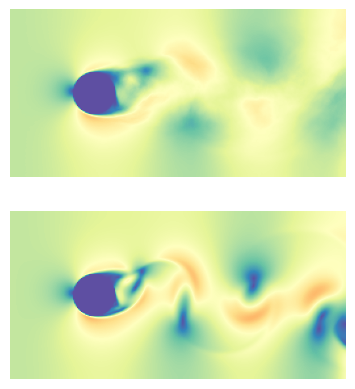

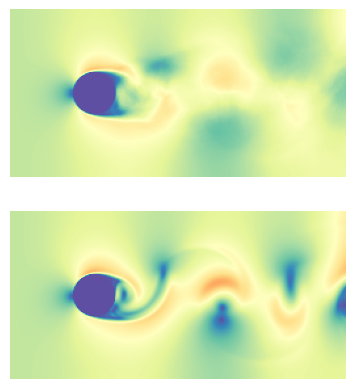

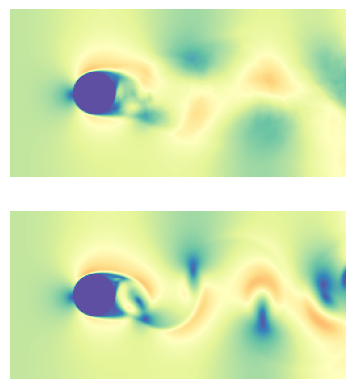

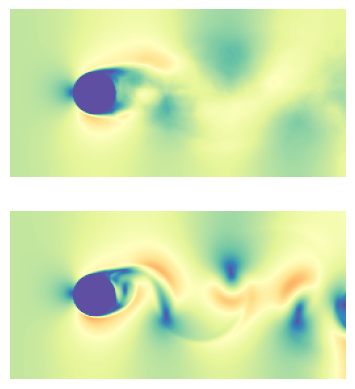

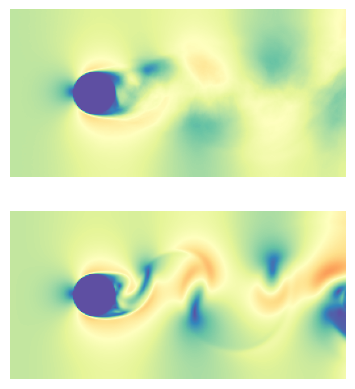

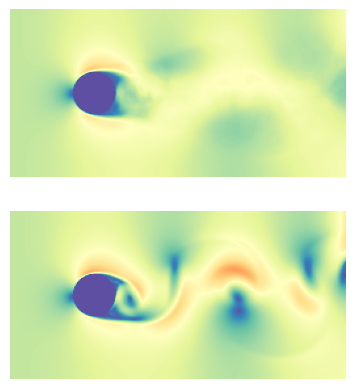

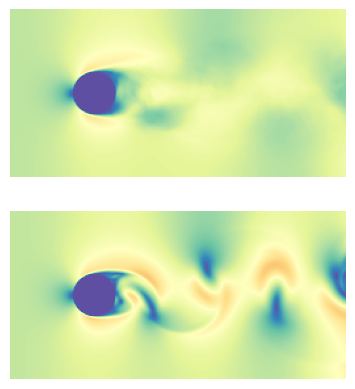

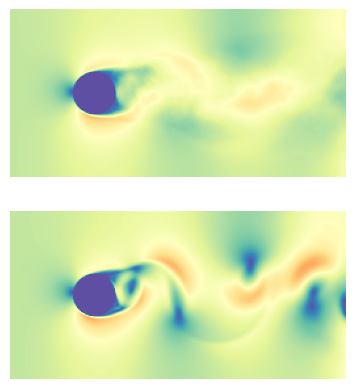

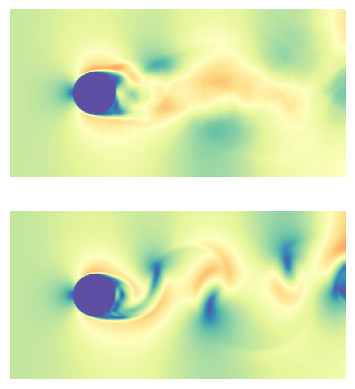

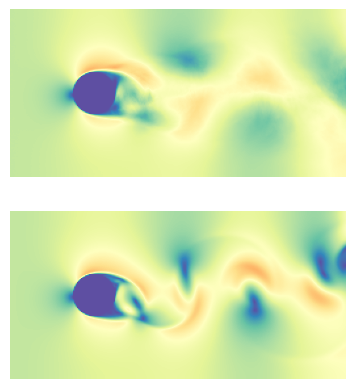

IndexError: index 39 is out of bounds for axis 0 with size 39

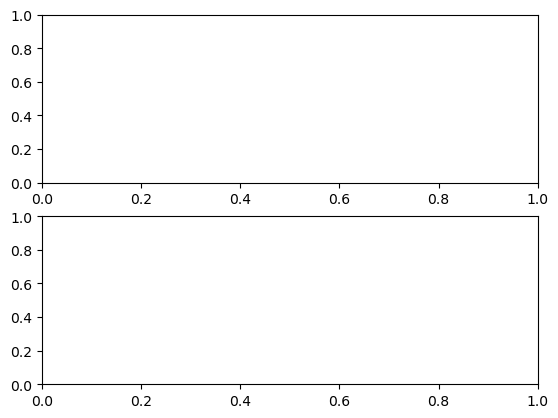

In [13]:
import matplotlib.pyplot as plt
for i in range(40):
    _, ax = plt.subplots(2,1)
    ax[0].imshow(reconstruction_sens[i,:,:,0], vmin= 0 ,vmax = 1, cmap = 'Spectral_r')
    ax[0].axis("off")
    ax[1].imshow(full_field_data_whole_test_norm[i+39*case_idx,:,:,0], vmin= 0 ,vmax = 1,cmap = 'Spectral_r')
    ax[1].axis("off")
    plt.show()